In [4]:
import gym
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
USE_GPU = True

torch.cuda.set_device(3)
# dtype = torch.cuda.FloatTensor # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)
print(torch.cuda.current_device())

using device: cuda
3


In [7]:
# 两层的全连接网络
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = F.relu( self.linear1(x))
        x = self.linear2(x)
        return x

In [12]:
class Agent(object):
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.eval_net = Net(self.state_space_dim, 256, self.action_space_dim).to(device)
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=self.lr)
        self.buffer = []
        self.steps = 0
    def act(self, s0):
        self.steps += 1
        epsi = self.epsi_low + (self.epsi_high-self.epsi_low) * (math.exp(-1.0 * self.steps/self.decay))
        if random.random() < epsi:
            a0 = random.randrange(self.action_space_dim)
        else:
            s0 =  torch.tensor(s0, dtype=torch.float,device=device).view(1,-1)
            a0 = torch.argmax(self.eval_net(s0)).item()
        return a0

    def put(self, *transition):
        if len( self.buffer)==self.capacity:
            self.buffer.pop(0)
        self.buffer.append(transition)
        
    def learn(self):
        if (len(self.buffer)) < self.batch_size:
            return
        
        samples = random.sample( self.buffer, self.batch_size)
        
        s0, a0, r1, s1 = zip(*samples)
        s0 = torch.tensor( s0, dtype=torch.float,device=device)
        a0 = torch.tensor( a0, dtype=torch.long,device=device).view(self.batch_size, -1)
        r1 = torch.tensor( r1, dtype=torch.float,device=device).view(self.batch_size, -1)
        s1 = torch.tensor( s1, dtype=torch.float,device=device)
        
        y_true = r1 + self.gamma * torch.max( self.eval_net(s1).detach(), dim=1)[0].view(self.batch_size, -1)
        y_pred = self.eval_net(s0).gather(1, a0)
        
#         print( y_pred)
#         print(y_true)
        
        loss_fn = nn.MSELoss()
        loss = loss_fn(y_pred, y_true)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot(self, score, mean):
        from IPython import display
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(20,10))
        plt.clf()
    
        plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(score)
        plt.plot(mean)
        plt.text(len(score)-1, score[-1], str(score[-1]))
        plt.text(len(mean)-1, mean[-1], str(mean[-1]))

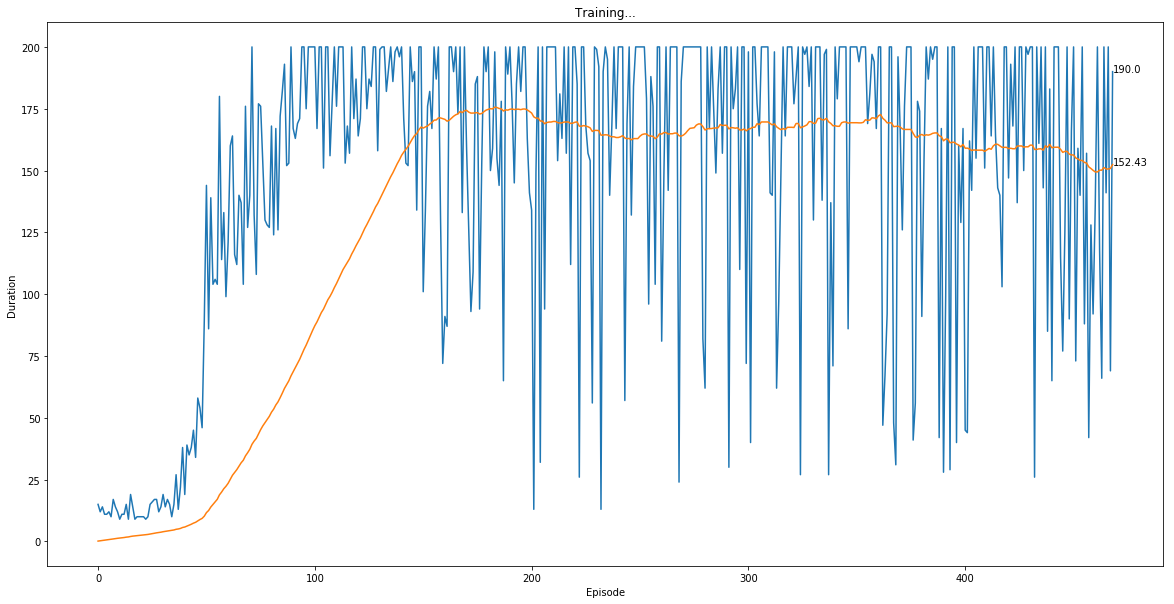

KeyboardInterrupt: 

KeyboardInterrupt: 

In [12]:
env = gym.make('CartPole-v0')

params = {
    'gamma': 0.8,
    'epsi_high': 0.9,
    'epsi_low': 0.05,
    'decay': 200, 
    'lr': 0.001,
    'capacity': 10000,
    'batch_size': 64,
    'state_space_dim': env.observation_space.shape[0],
    'action_space_dim': env.action_space.n   
}
agent = Agent(**params)

score = []
mean = []

#FIXME:  没有间隔固定步数更新y_true的参数
for episode in range(1000):
    s0 = env.reset()
    total_reward = 1
    while True:
        env.render()
        a0 = agent.act(s0)
        s1, r1, done, _ = env.step(a0)
        
        if done:
            r1 = -1
            
        agent.put(s0, a0, r1, s1)#加入到memory中
        
        if done:
            break

        total_reward += r1
        s0 = s1
        agent.learn() #minibatch训练NN
    
    #一轮模拟结束
    score.append(total_reward)
    mean.append( sum(score[-100:])/100)
    agent.plot(score, mean)

In [22]:
####  一些shape问题

#neural network inputsize
def shape_NN():
    """
    [position of cart, velocity of cart, angle of pole, rotation rate of pole] 四维状态
    良好的通用代理人不需要知道观察的语义：
    他们可以学习如何将观察结果映射到行动，以在没有任何先验知识的情况下最大化奖励。
    """
    print (env.observation_space.shape[0])

shape_NN()

4


In [23]:
# view 相当于reshape
sum=[1,2,3,4]
print(sum[-2:])

[3, 4]


In [25]:
#e-greedy更新随机概率
#epsi = self.epsi_low + (self.epsi_high-self.epsi_low) * (math.exp(-1.0 * self.steps/self.decay))
#math exp 指的是e的指数次方
#随机概率epsi{0.9,0.05}之间减少

In [1]:
#optimizer 优化器 来计算梯度
#使用learning rate速率下降   或者采用动量的下降方式Adam

In [2]:
def predict_y():
    """
    y_true = r1 + self.gamma * torch.max( self.eval_net(s1).detach(), dim=1)[0].view(self.batch_size, -1)
    y_pred = self.eval_net(s0).gather(1, a0)
    
    其中gather函数将dim=1维度的,index=a0的数据加以收集(==minibath所有的Q值)
    """

In [2]:
#加入 model to(device)   以及tensor to(device)  完成了cuda加速